# **Model : Multi-layer Perceptron (MLP)**

> **Reference:**

> *E. Ramalakshmi and S. R. Kamidi, “Prediction of employee attrition and analyzing reasons: Using multi-layer perceptron in Spark,” in Springer eBooks, 2019, pp. 183–192. [Online]. Available: [https://link.springer.com/chapter/10](https://link.springer.com/chapter/10.1007/978-981-13-8461-5_20)*


Take a copy of this notebook for each model you will implement.

This is the initial notebook — any changes will be made here before starting model building to ensure consistency across all notebooks.

**Key Consistency Tips**

* Standardized Headings: Use identical section names across all notebooks.

* Code Comments: Explain non-trivial steps (e.g., "Handling class imbalance with SMOTE").

* Version Control: Add a requirements.txt in the repo for dependency management. مش لازم

* Outputs: Save all plots/figures to a /results folder with consistent naming (e.g., XGBoost_SHAP.png).
اعتقد هتبقى كويسة عشان واحنا بنعمل البيبر ما نقعدش ناخد سكرينات


* Reproducibility: Set global random seeds (e.g., np.random.seed(42)).

# **Imports**

In [36]:
%%capture
!pip install -q lime shap

In [37]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import kagglehub
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, learning_curve, ValidationCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.inspection import PartialDependenceDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor

import os
import warnings
warnings.filterwarnings('ignore')



In [38]:
if not os.path.exists('results'):
    os.makedirs('results')

# **Utils**

In [39]:
def our_confusion_matrix(model, name='Model'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, cmap="Oranges", ax=ax1)
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap="Oranges", ax=ax2)
    plt.title(f"{name} Confusion Matrix")
    plt.savefig(f'results/{name}_confusion_matrix.png')
    plt.show()
    plt.close()

def our_roc(model, name="Model"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    roc1 = RocCurveDisplay.from_estimator(model, X_train, y_train, name=name, ax=ax1, color="orange")
    roc2 = RocCurveDisplay.from_estimator(model, X_test, y_test, name=name, ax=ax2, color="blue")
    ax1.fill_between(roc1.fpr, roc1.tpr, alpha=0.4, color="orange")
    ax2.fill_between(roc2.fpr, roc2.tpr, alpha=0.4, color="blue")
    ax1.set_title(f"{name} Training ROC Curve", fontsize=16)
    ax2.set_title(f"{name} Testing ROC Curve", fontsize=16)
    for ax in [ax1, ax2]:
        ax.grid(alpha=0.5)
    plt.savefig(f'results/{name}_roc_curve.png')
    plt.show()
    plt.close()

def our_learning_curve(model, name='Model'):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=0
    )
    plt.figure(figsize=(13, 8))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="mediumseagreen", label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="royalblue", label="Cross-validation score")
    plt.title(f"{name} Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid(alpha=0.5)
    plt.savefig(f'results/{name}_learning_curve.png')
    plt.show()
    plt.close()

def our_prc(model, name="Model"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 13))
    train_disp = PrecisionRecallDisplay.from_estimator(model, X_train, y_train, ax=ax1, color='orange')
    test_disp = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax2, color='blue')
    ax1.set_title(f"{name} Precision-Recall Curve - Train")
    ax2.set_title(f"{name} Precision-Recall Curve - Test")
    ax1.fill_between(train_disp.recall, train_disp.precision, alpha=0.4, color='orange')
    ax2.fill_between(test_disp.recall, test_disp.precision, alpha=0.4, color='blue')
    plt.savefig(f'results/{name}_precision_recall_curve.png')
    plt.show()
    plt.close()


# **Load Processed Dat**a

In [40]:
path = kagglehub.dataset_download('mohamedhassan77/xai-project-processed-data')
df = pd.read_csv(f"{path}/combined_adasyn_train_test.csv")
df

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,promotion_velocity,workload_score,compensation_ratio,Attrition,Set
0,31,2,1062,1,24,3,3,3,0,96,...,3,10.0,9,1,8,9.999900,1,1.019760,0,Train
1,50,2,328,1,1,3,3,3,1,86,...,2,3.0,2,0,2,300000.000000,2,1.281918,0,Train
2,46,2,717,1,13,4,1,3,1,34,...,3,10.0,7,0,9,1000000.000000,1,0.832635,0,Train
3,44,2,170,1,1,4,1,2,1,78,...,3,2.0,0,2,2,0.999995,1,0.753443,0,Train
4,26,1,1479,1,1,3,1,3,0,84,...,1,6.0,5,1,4,5.999940,3,1.007878,0,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2042,56,2,1162,1,24,2,1,1,1,97,...,3,4.0,2,1,0,3.999960,1,0.898732,1,Test
2043,46,2,669,2,9,2,3,3,1,64,...,3,9.0,8,4,7,2.249994,1,1.558490,1,Test
2044,30,2,1240,0,9,3,0,3,1,48,...,1,11.0,9,4,7,2.749993,7,2.052053,0,Test
2045,31,2,741,1,2,4,1,2,1,69,...,4,5.0,2,0,3,500000.000000,0,1.207921,0,Test


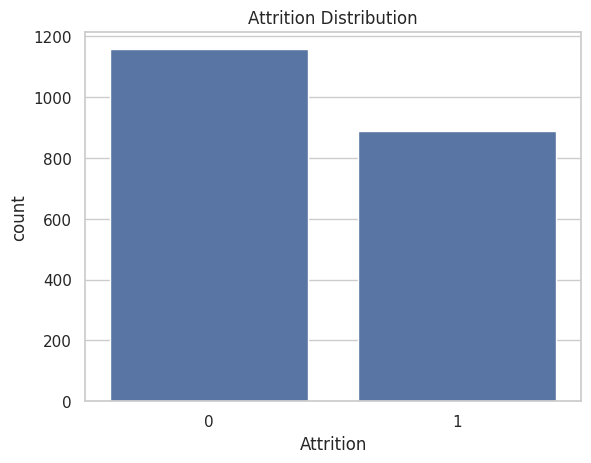

In [41]:
sns.countplot(x='Attrition', data=df)
plt.title('Attrition Distribution')
plt.show()

In [42]:
train_df = df[df['Set'] == 'Train'].drop(columns=['Set'])
test_df = df[df['Set'] == 'Test'].drop(columns=['Set'])

X_train = train_df.drop(columns=['Attrition'])
y_train = train_df['Attrition']

X_test = test_df.drop(columns=['Attrition'])
y_test = test_df['Attrition']

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (1589, 33) y_train: (1589,)
X_test: (458, 33) y_test: (458,)


# **Model-Specific EDA (Optional)**

Correlation and KDE plots


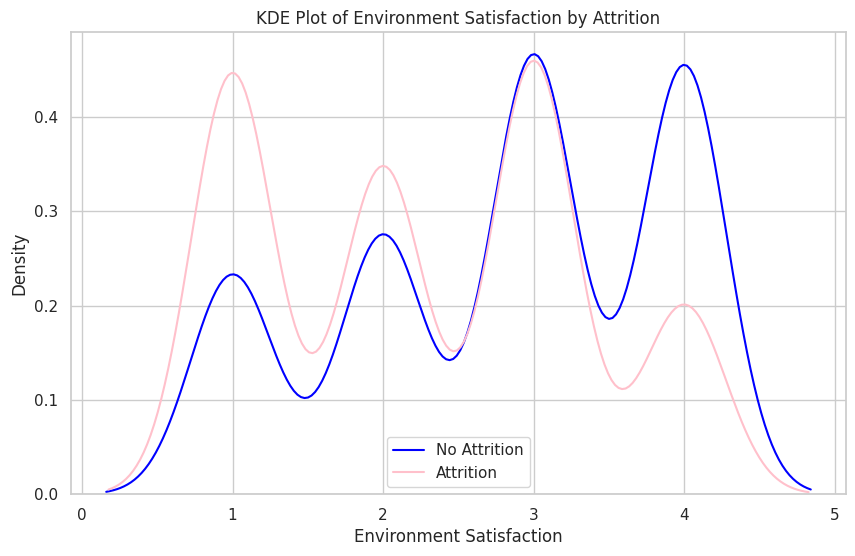

In [43]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=train_df[train_df['Attrition'] == 0], x='EnvironmentSatisfaction', label='No Attrition', color='blue')
sns.kdeplot(data=train_df[train_df['Attrition'] == 1], x='EnvironmentSatisfaction', label='Attrition', color='pink')
plt.title('KDE Plot of Environment Satisfaction by Attrition')
plt.xlabel('Environment Satisfaction')
plt.legend()
plt.savefig('results/mlp_environment_satisfaction_kde.png')
plt.show()
plt.close()

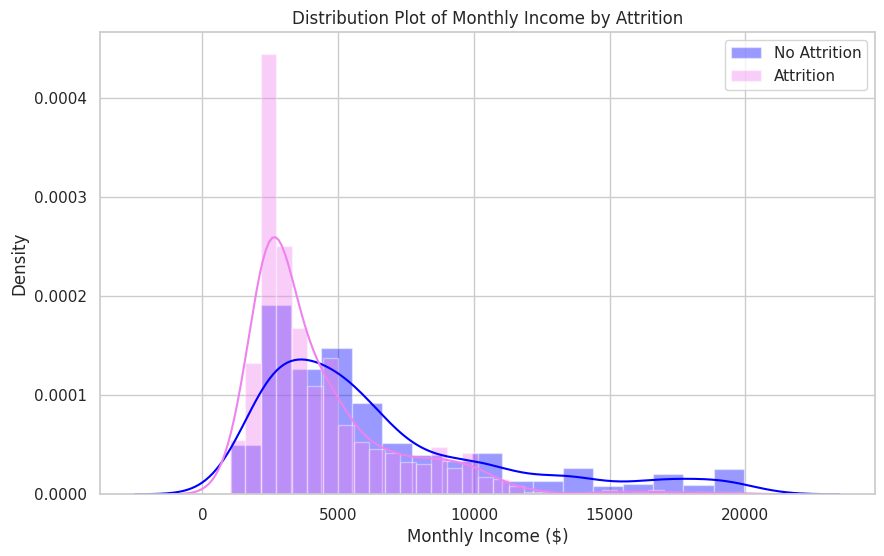

In [44]:
plt.figure(figsize=(10, 6))
sns.distplot(train_df[train_df['Attrition'] == 0]['MonthlyIncome'], label='No Attrition', color='blue')
sns.distplot(train_df[train_df['Attrition'] == 1]['MonthlyIncome'], label='Attrition', color='violet')
plt.title('Distribution Plot of Monthly Income by Attrition')
plt.xlabel('Monthly Income ($)')
plt.legend()
plt.savefig('results/mlp_monthly_income_dist.png')
plt.show()
plt.close()

# **Model Initialization**

In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [46]:
model = MLPClassifier(hidden_layer_sizes=(256, 128, 64),
              learning_rate='adaptive',
              learning_rate_init=0.0005,
              alpha=0.0001,
              momentum=0.9,
              max_iter=100,
              validation_fraction=0.1,
              n_iter_no_change=50,
              random_state=42)


model

MLPClassifier(hidden_layer_sizes=(256, 128, 64), learning_rate='adaptive',
              learning_rate_init=0.0005, max_iter=100, n_iter_no_change=50,
              random_state=42)

# **Model Training**

In [47]:
model.fit(X_train_scaled, y_train)

MLPClassifier(hidden_layer_sizes=(256, 128, 64), learning_rate='adaptive',
              learning_rate_init=0.0005, max_iter=100, n_iter_no_change=50,
              random_state=42)

# **Model Evaluation**

In [48]:
y_pred = model.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Accuracy: 0.8057


In [49]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Attrition', 'Attrition']))


Classification Report:
              precision    recall  f1-score   support

No Attrition       0.86      0.91      0.88       373
   Attrition       0.47      0.34      0.39        85

    accuracy                           0.81       458
   macro avg       0.66      0.63      0.64       458
weighted avg       0.79      0.81      0.79       458



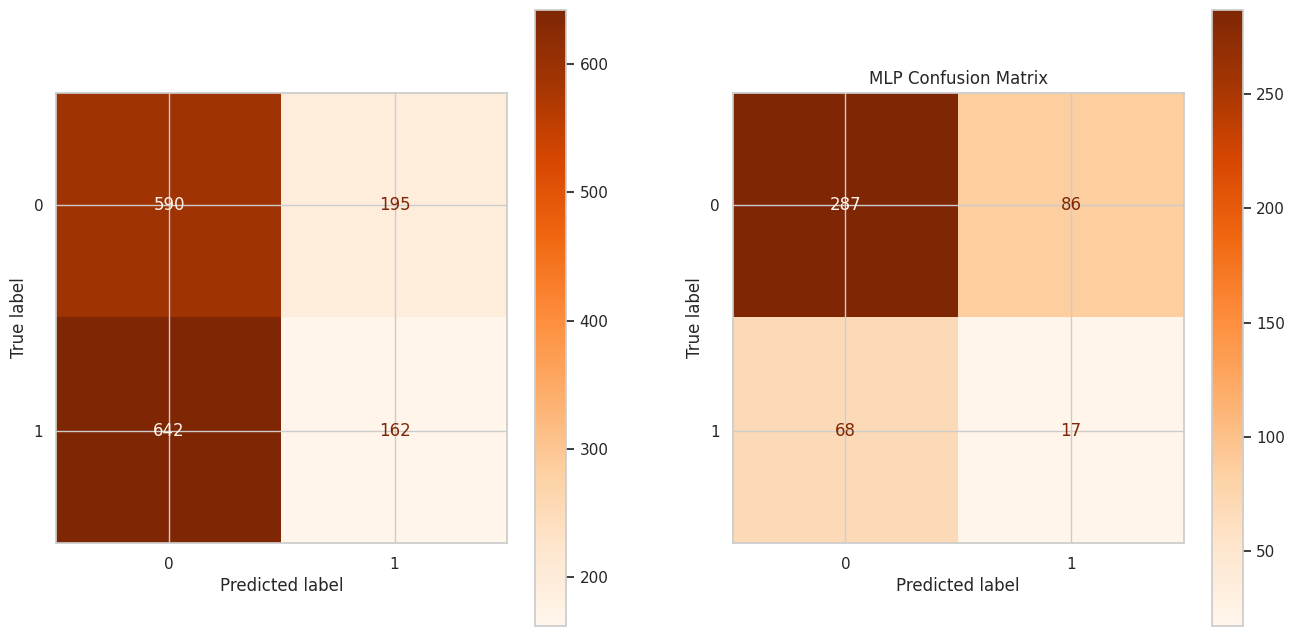

In [50]:
our_confusion_matrix(model, 'MLP')

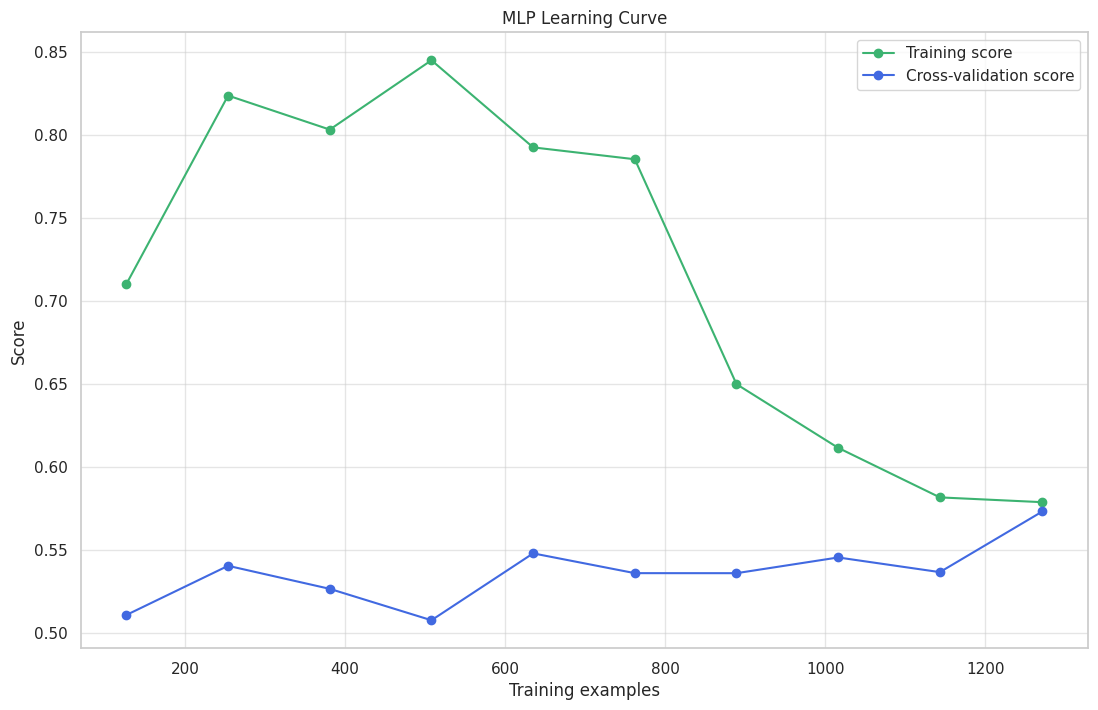

In [51]:
our_learning_curve(model, 'MLP')

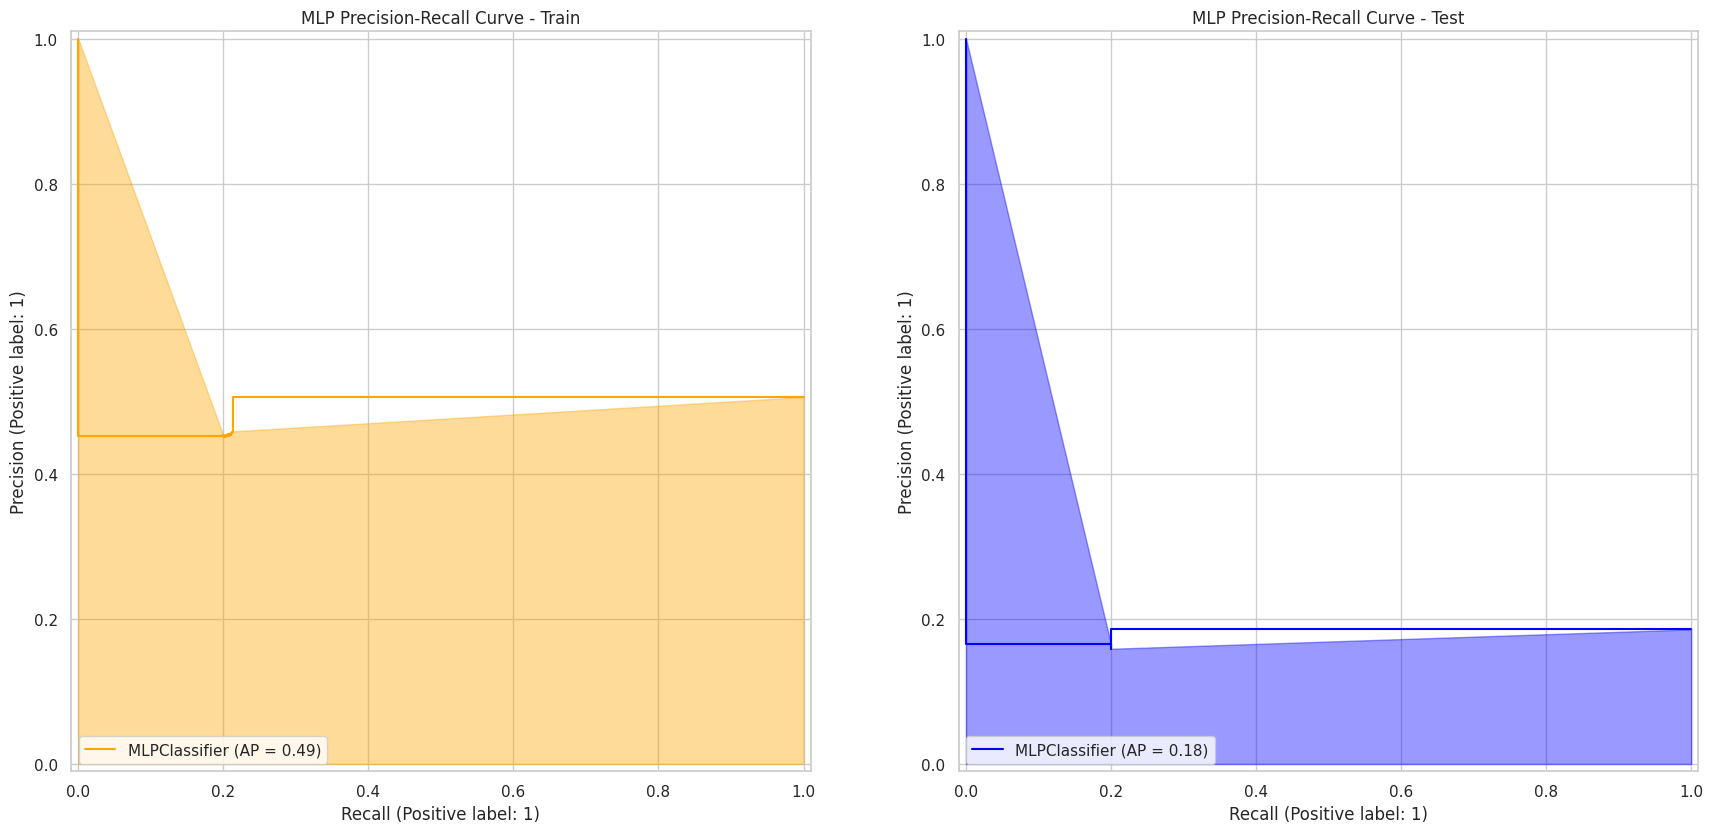

In [52]:
our_prc(model, 'MLP')

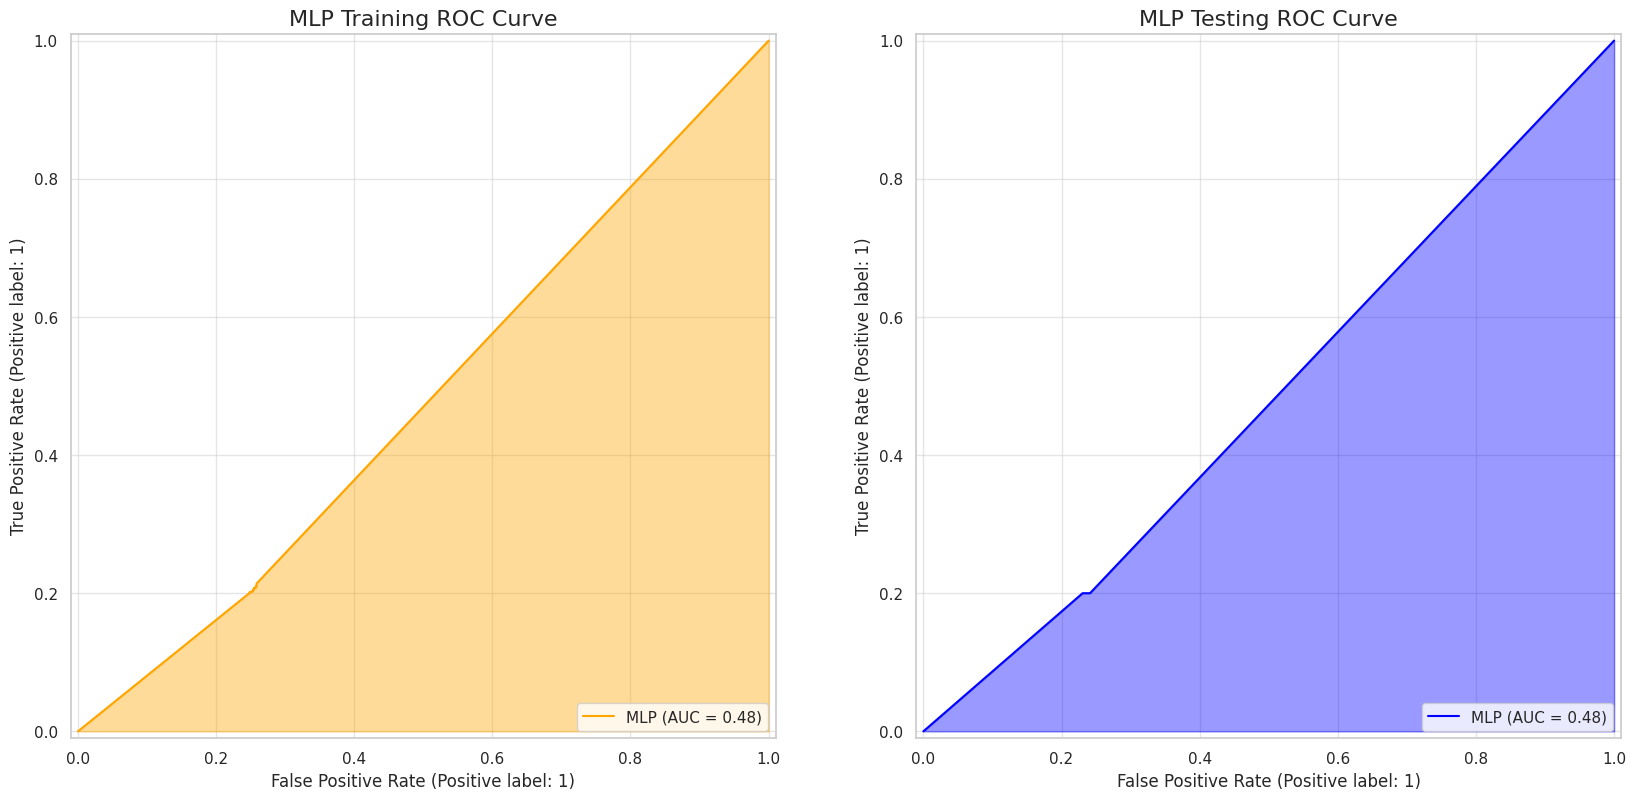

In [53]:
our_roc(model, 'MLP')

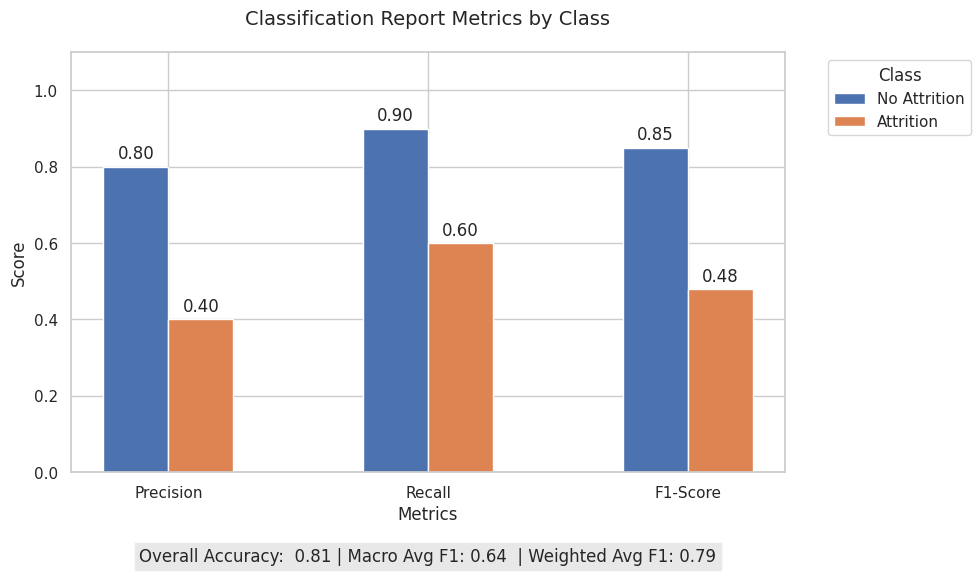

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Data derived from test set confusion matrix
metrics = ['Precision', 'Recall', 'F1-Score']
classes = ['No Attrition', 'Attrition']
values = np.array([
    [0.80, 0.90, 0.85],  # No Attrition
    [0.40, 0.60, 0.48]   # Attrition
])

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

bar_width = 0.25
index = np.arange(len(metrics))

for i, class_name in enumerate(classes):
    plt.bar(index + i * bar_width, values[i], bar_width, label=class_name)

# Text annotations
for i in range(values.shape[0]):
    for j in range(values.shape[1]):
        plt.text(j + i * bar_width, values[i][j] + 0.01,
                 f"{values[i][j]:.2f}",
                 ha='center', va='bottom')

plt.title('Classification Report Metrics by Class', fontsize=14, pad=20)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(index + bar_width / 2, metrics)
plt.ylim(0, 1.1)
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add accuracy
plt.text(0.5, -0.2,
         f"Overall Accuracy:  0.81 | Macro Avg F1: 0.64  | Weighted Avg F1: 0.79",
         ha='center', va='center', transform=plt.gca().transAxes,
         bbox=dict(facecolor='lightgray', alpha=0.5))

plt.tight_layout()
plt.savefig('results/logistic_regression_classification_report.png')
plt.show()
plt.close()

## **Check for some Assumptions:**

In [55]:
def check_homoscedasticity(y_pred, residuals, ylim=(-10, 10), xlim=(0, 26)):

    p = sns.scatterplot(x=y_pred, y=residuals)
    plt.xlabel('y_pred / predicted values')
    plt.ylabel('Residuals')
    plt.ylim(ylim)
    plt.xlim(xlim)
    p = sns.lineplot(x=[xlim[0], xlim[1]], y=[0, 0], color='blue')
    p = plt.title('Homoscedasticity Check')
    return p

In [56]:
def check_multicollinearity(features, vif_threshold=10):
    vif = pd.Series(
        [variance_inflation_factor(features.values, i)
         for i in range(features.shape[1])],
        index=features.columns
    )
    return list(vif[vif > vif_threshold].index)

In [57]:
def  mean_of_residuals(residuals):
    return np.mean(residuals)

In [69]:
check_homoscedasticity(y_test, y_pred)

Text(0.5, 1.0, 'Homoscedasticity Check')

In [59]:
residuals = y_pred - y_test
print(mean_of_residuals(residuals))

-0.05021834061135371


In [60]:
high_vif = check_multicollinearity(X_train, vif_threshold=10)
print("High-VIF features:", high_vif)

High-VIF features: ['Age', 'Department', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'MonthlyIncome', 'PercentSalaryHike', 'PerformanceRating', 'TotalWorkingYears', 'WorkLifeBalance', 'YearsAtCompany', 'workload_score', 'compensation_ratio']


# **Explainability Techniques**

## LIME Analysis

In [61]:
from lime.lime_tabular import LimeTabularExplainer

class_names = ['Attrition','No Attrition']
feature_names = list(X_train.columns)
explainer = LimeTabularExplainer(X_train_scaled, feature_names=feature_names,
                                 class_names=class_names, mode='classification')
exp = explainer.explain_instance(X_test_scaled[1], model.predict_proba, num_features=len(feature_names))
exp.show_in_notebook(show_table=True)
# exp.save_to_file('results/mlp_lime_explanation.html')

<Figure size 1000x600 with 0 Axes>

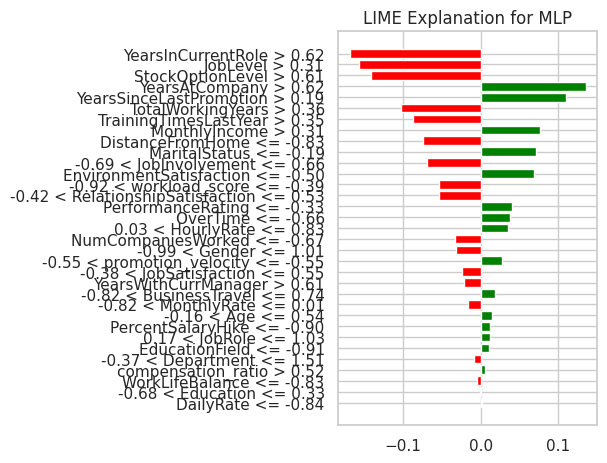

In [71]:
plt.figure(figsize=(10, 6))
exp.as_pyplot_figure()
plt.title('LIME Explanation for MLP')
plt.tight_layout()
plt.savefig('results/mlp_lime_bar.png')
plt.show()
plt.close()

## SHAP Analysis

  0%|          | 0/10 [00:00<?, ?it/s]

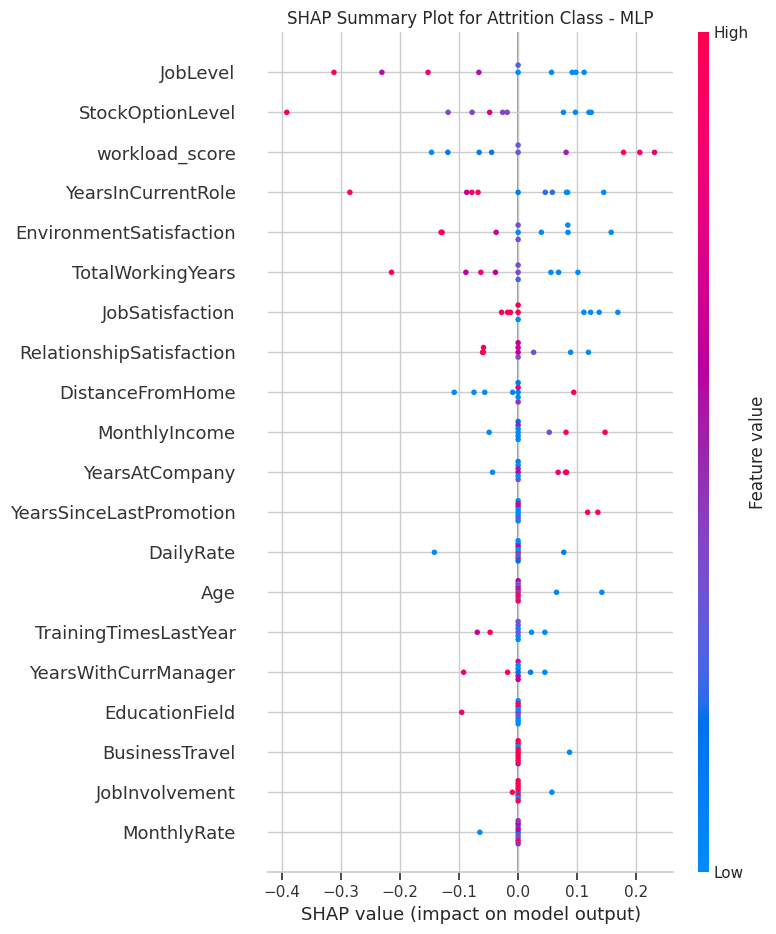

In [63]:
import shap

explainer = shap.KernelExplainer(model.predict_proba, X_test_scaled[:50])
shap_values = explainer.shap_values(X_test_scaled[:10])

# SHAP plot for class attrition
plt.figure()
shap.summary_plot(shap_values[:, :, 1], X_test.iloc[:10], show=False)
plt.title('SHAP Summary Plot for Attrition Class - MLP')
plt.tight_layout()
plt.savefig('results/mlp_shap_summary_attrition.png')
plt.show()
plt.close()

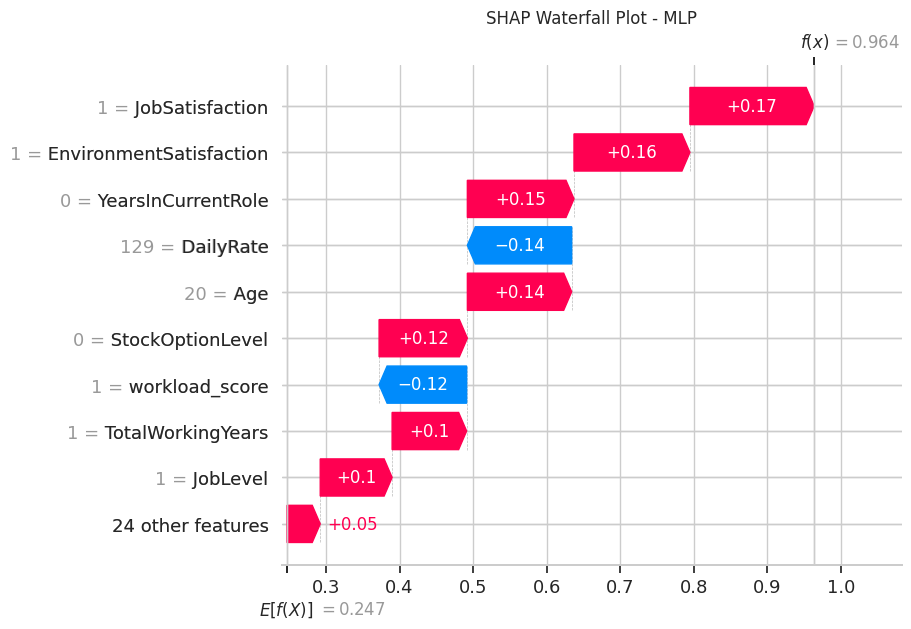

In [64]:
# SHAP Waterfall Plot :
shap_values_exp = shap.Explanation(
    values=shap_values[0][:, 1],
    base_values=explainer.expected_value[1],
    data=X_test.iloc[0],
    feature_names=X_test.columns
)
plt.figure()
shap.waterfall_plot(shap_values_exp, max_display=10, show=False)
plt.title(f"SHAP Waterfall Plot - MLP")
plt.savefig('results/mlp_shap_waterfall_attrition.png')
plt.show()
plt.close()

## Feature Importance (Model-Specific)

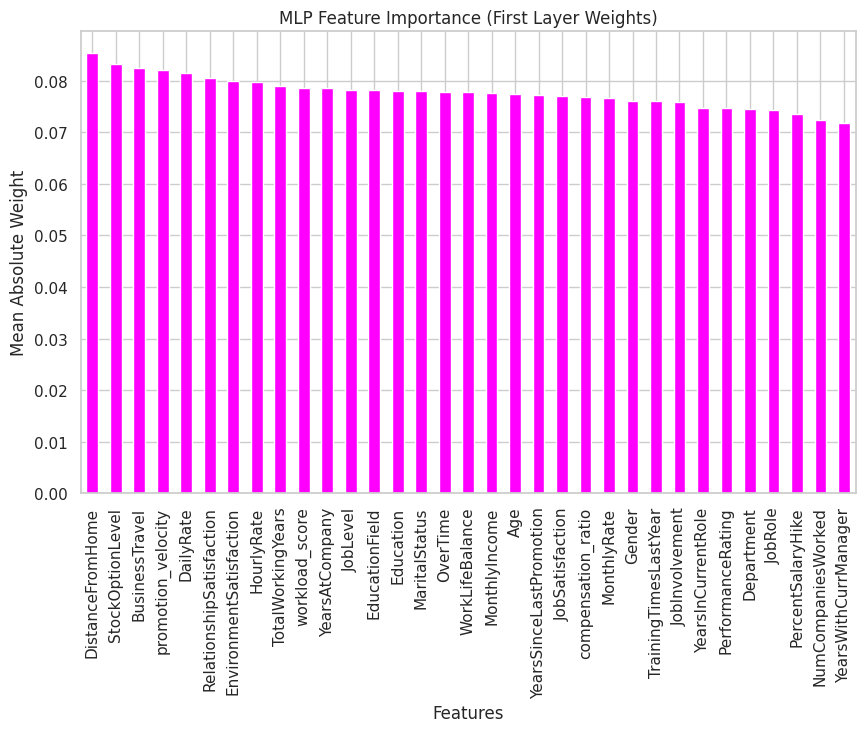

In [65]:
#from the first layer, get the weights
first_w = np.abs(model.coefs_[0]).mean(axis=1)
feature_importance = pd.Series(first_w, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar', color='fuchsia')
plt.title("MLP Feature Importance (First Layer Weights)")
plt.xlabel("Features")
plt.ylabel("Mean Absolute Weight")
plt.savefig('results/mlp_feature_importance_weights.png')
plt.show()
plt.close()


## Partial Dependence Plots

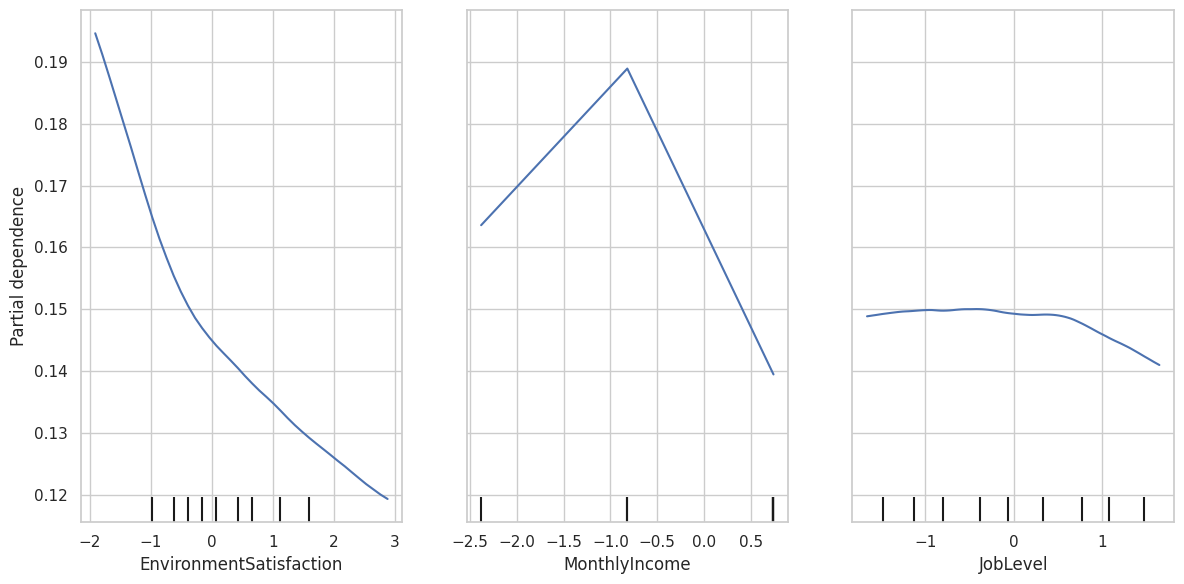

In [73]:
from sklearn.inspection import PartialDependenceDisplay

features = ['EnvironmentSatisfaction', 'MonthlyIncome','JobLevel']
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(model, X_test_scaled,features, feature_names=features, ax=ax)
plt.tight_layout()
plt.savefig('results/mlp_partial_dependence.png')
plt.show()
plt.close()

### **Permutation Feature Importance (PFI)**


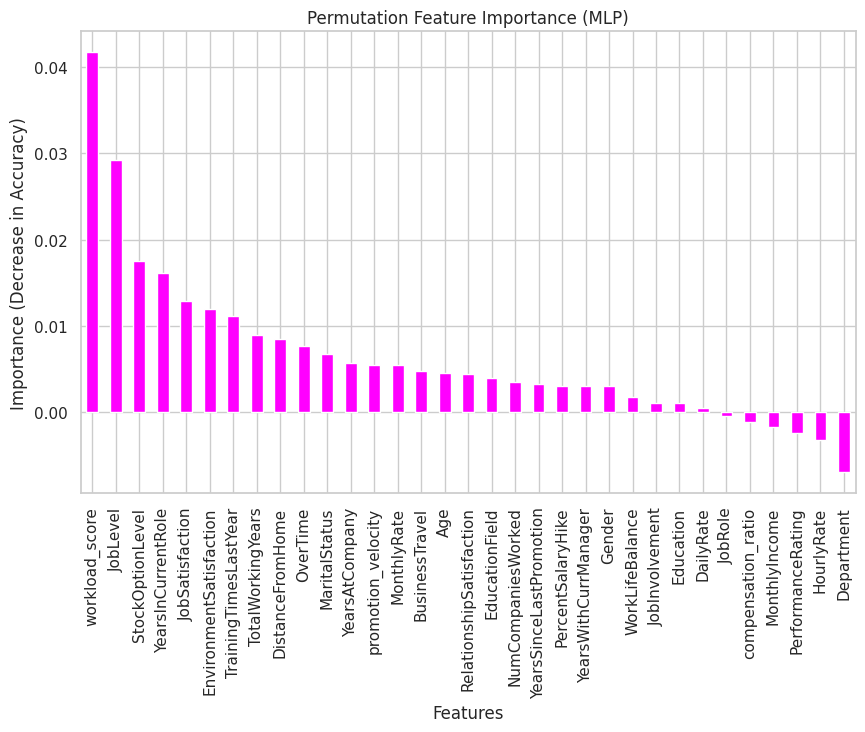

In [67]:
from sklearn.inspection import permutation_importance

pfi_result = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42, scoring='accuracy')
pfi_importance = pd.Series(pfi_result.importances_mean, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
pfi_importance.plot(kind='bar', color='fuchsia')
plt.title("Permutation Feature Importance (MLP)")
plt.xlabel("Features")
plt.ylabel("Importance (Decrease in Accuracy)")
plt.savefig('results/mlp_permutation_importance.png')
plt.show()
plt.close()



##**ICE Plot**

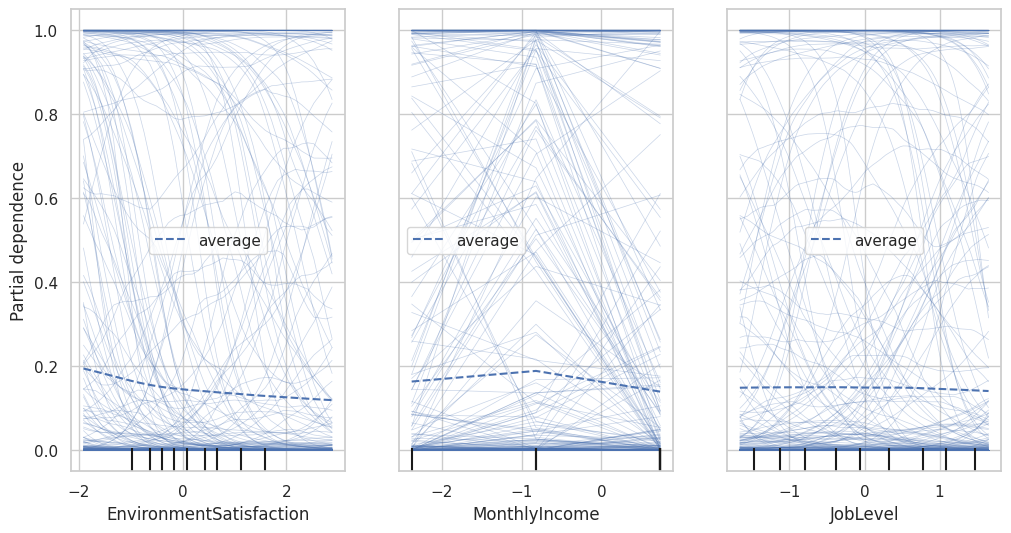

In [68]:
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(model, X_test_scaled, features, feature_names=features, kind='both', ax=ax)
plt.savefig('results/mlp_ice_plots.png')
plt.show()
plt.close()